# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
# Train data preprocessing (with augmentation + scaling)
transforms_cifar10_train = transforms.Compose([
    transforms.Resize((36, 36)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Test data preprocessing (with scaling only)
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
#배치 사이즈 바꿔도 됨, 셔플은 학습순서 기억하지 못하도록 하기 위해 사용.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
#배치 사이즈 바꿔도 됨, test는 셔플 필요없음 .

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

 ship   dog  ship  frog


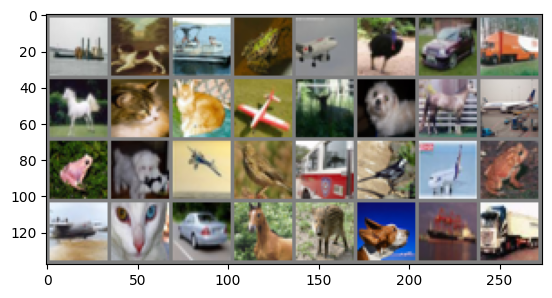

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# PyramidNet(84%)

class PyramidNet(nn.Module):
    def __init__(self, num_classes=10):
        super(PyramidNet, self).__init__()
        self.in_planes = 16
        # ⬇️ 초기 입력 채널 3을 16으로 맞춰주는 Conv layer 추가
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._make_layer(32, 4, stride=1)   # 4 blocks
        self.layer2 = self._make_layer(64, 6, stride=2)   # 6 blocks
        self.layer3 = self._make_layer(128, 8, stride=2)  # 8 blocks
        self.linear = nn.Linear(128, num_classes)

    def _make_layer(self, out_planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, out_planes, s))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return self.linear(out)

In [ ]:
# DenseNet 구현(82%)

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        return self.pool(out)

class DenseNetMini(nn.Module):
    def __init__(self, growth_rate=16, num_classes=10):
        super(DenseNetMini, self).__init__()
        num_layers = 8
        init_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, init_channels, kernel_size=3, padding=1, bias=False)

        self.block1 = DenseBlock(init_channels, num_layers, growth_rate)
        self.trans1 = Transition(init_channels + num_layers * growth_rate, init_channels)

        self.block2 = DenseBlock(init_channels, num_layers, growth_rate)
        self.trans2 = Transition(init_channels + num_layers * growth_rate, init_channels)

        self.block3 = DenseBlock(init_channels, num_layers, growth_rate)
        self.trans3 = Transition(init_channels + num_layers * growth_rate, init_channels)

        self.bn = nn.BatchNorm2d(init_channels)
        self.fc = nn.Linear(init_channels, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return self.fc(out)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# 모델 정의
model = PyramidNet(num_classes=10).to(device)

#SGD + Momentum + StepLR 조합으로 수정(Adam + CosineAnnealingLR 조합보다 정확도 높음, 단 추가 실험 필요)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 정확도 계산 함수
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model
epochs = 30  # number of epochs

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = model(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.386
[Epoch - 2] Loss: 0.893
[Epoch - 3] Loss: 0.691
[Epoch - 4] Loss: 0.553
[Epoch - 5] Loss: 0.466
[Epoch - 6] Loss: 0.381
[Epoch - 7] Loss: 0.315
[Epoch - 8] Loss: 0.266
[Epoch - 9] Loss: 0.214
[Epoch - 10] Loss: 0.181
[Epoch - 11] Loss: 0.062
[Epoch - 12] Loss: 0.025
[Epoch - 13] Loss: 0.016
[Epoch - 14] Loss: 0.012
[Epoch - 15] Loss: 0.009
[Epoch - 16] Loss: 0.007
[Epoch - 17] Loss: 0.007
[Epoch - 18] Loss: 0.007
[Epoch - 19] Loss: 0.007
[Epoch - 20] Loss: 0.006
[Epoch - 21] Loss: 0.004
[Epoch - 22] Loss: 0.003
[Epoch - 23] Loss: 0.002
[Epoch - 24] Loss: 0.002
[Epoch - 25] Loss: 0.002
[Epoch - 26] Loss: 0.002
[Epoch - 27] Loss: 0.001
[Epoch - 28] Loss: 0.002
[Epoch - 29] Loss: 0.002
[Epoch - 30] Loss: 0.001
Finished Training


# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


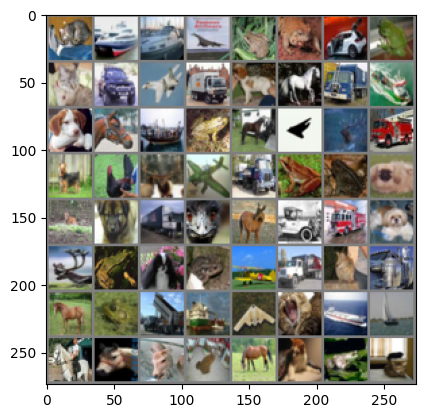

In [57]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [58]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = model(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 82 %
